<a href="https://colab.research.google.com/github/sebasbrowar/FisicaComputacional1/blob/main/Actividad6/Actividad6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\text{Actividad 6 - Pronóstico de Series de Tiempo}$

## $\text{Bibliotecas y DataFrame}$

In [3]:
# Feb 15, 2021
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

In [4]:
# En esta celda se hacen todas las operaciones de preparar el DataFrame df_meteo
# 
# En esta nueva Jupyter Notebook, en una celda vamos a concentrar todas las operaciones
# de transformación del dataframe original df_dist

# Analizaremos los datos de Información Estadística Climatológica del Servico Meteorológico Nacional 
# de CONAGUA que podemos descargar del sitio:
# (https://smn.conagua.gob.mx/es/climatologia/informacion-climatologica/informacion-estadistica-climatologica) 

# Tomar la dirección URL del archivo en formato 'raw'
url = 'https://raw.githubusercontent.com/sebasbrowar/FisicaComputacional1/main/Actividad6/2038.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_work2['Fecha']=pd.to_datetime(df_work2['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_work2['Año'] = df_work2['Fecha'].dt.year
df_work2['Mes'] = df_work2['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_work2.copy()

#df_meteo.info()
#print(df_meteo.head())
#print(df_meteo.tail())

# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_ts = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_ts = df_meteo_ts.set_index('Fecha')

# Verificamos
df_meteo_ts.info()
#print(df_meteo_ts.head())
#print(df_meteo_ts.tail())

# Seleccionaremos un conjunto de años de 30 años, creando las colecciones de datos 
df_30 = df_meteo_ts[(df_meteo_ts['Año'] >= 1930) & (df_meteo_ts['Año'] < 1960)]
df_60 = df_meteo_ts[(df_meteo_ts['Año'] >= 1960) & (df_meteo_ts['Año'] < 1990)]
df_90 = df_meteo_ts[(df_meteo_ts['Año'] >= 1990) & (df_meteo_ts['Año'] < 2013)]

# Estas 3 colecciones serán nuestras Series de Tiempo (DatFrames) para el análisis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28868 entries, 1929-01-01 to 2012-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  28843 non-null  float64
 1   Evap    28117 non-null  float64
 2   Tmax    28727 non-null  float64
 3   Tmin    28756 non-null  float64
 4   Año     28868 non-null  int64  
 5   Mes     28868 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.5+ MB


## $\text{Función para probar la estacionaridad de una serie de tiempo: 'timeseries'}$

In [7]:
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [8]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1990 a 2013 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '1999-01', '2002-12' 

ts_90 = df_90.loc[start:end].copy()
print(ts_90.head())
print(ts_90.tail())

            Precip  Evap  Tmax  Tmin   Año  Mes
Fecha                                          
1999-01-01     0.0   3.1  21.0   7.0  1999  Jan
1999-01-02     0.0   2.6  27.0   6.5  1999  Jan
1999-01-03     0.0   7.7  23.0   9.0  1999  Jan
1999-01-04     0.0   4.5  26.0  13.5  1999  Jan
1999-01-05     0.0   4.2  26.0  10.0  1999  Jan
            Precip  Evap  Tmax  Tmin   Año  Mes
Fecha                                          
2002-12-27     0.0   1.5  23.0   4.5  2002  Dec
2002-12-28     6.2   3.4  22.0   6.5  2002  Dec
2002-12-29     2.9   0.9  15.0  10.0  2002  Dec
2002-12-30     0.0   1.0  18.0   7.0  2002  Dec
2002-12-31     0.0   1.0  17.0   6.5  2002  Dec


## $\text{Seleccionamos y preparamos las series Tmax y Tmin}$

In [10]:
# Vemos su encabezado
print(ts_90['Tmax'].head())
print(ts_90['Tmin'].head())

Fecha
1999-01-01    21.0
1999-01-02    27.0
1999-01-03    23.0
1999-01-04    26.0
1999-01-05    26.0
Name: Tmax, dtype: float64
Fecha
1999-01-01     7.0
1999-01-02     6.5
1999-01-03     9.0
1999-01-04    13.5
1999-01-05    10.0
Name: Tmin, dtype: float64


In [12]:
# Definimos las Serie de Tiempo que vamos a estudiar, le damos un nombre genérico
ts_test = ts_90['Tmax'].copy()
ts_test2 = ts_90['Tmin'].copy()

## $\text{Verificamos la Estacionaridad de Tmax}$

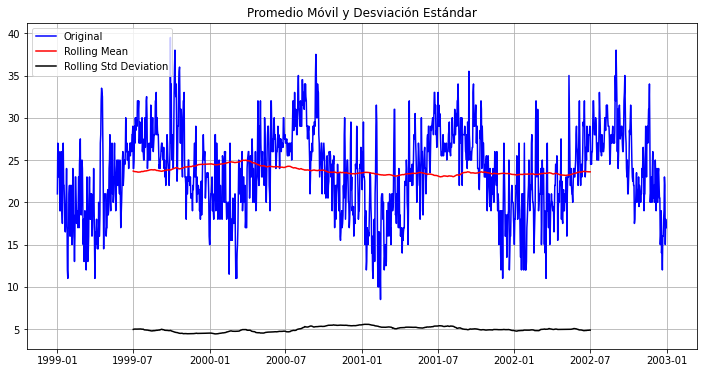

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.236612
p-value                           0.017961
#Lags Used                       22.000000
Number of Observations Used    1438.000000
Critical Value (1%)              -3.434906
Critical Value (5%)              -2.863552
Critical Value (10%)             -2.567841
dtype: float64


In [52]:
# Realizamos la Prueba de Estacionaridad de Tmax
test_stationarity(ts_test)

$\text{Se puede observar que el valor p = 0.017961 < 0.05 por lo que podemos afirmar que la serie de tiempo es estacionaria con 99% de confianza.}$
$\text{Se puede decir que la serie es estacionaria, pues tanto el promedio móvil exponencial y la desviación estandar son constantes.}$

## $\text{Verificamos la Estacionaridad de Tmin}$

$\text{Para Tmin habrá que hacer algunos cambios, ya que p > 0.05 y tiene datos faltantes.}$

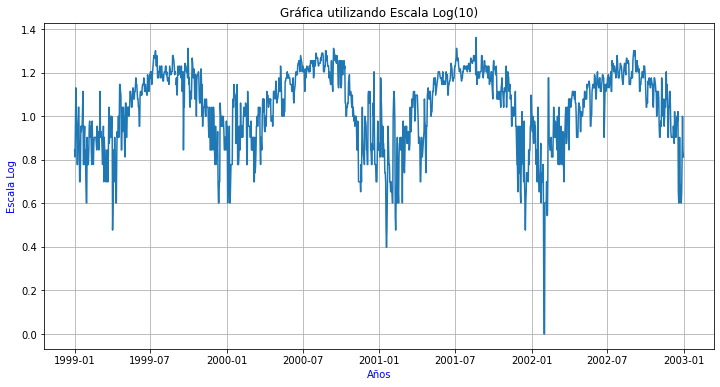

In [28]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test2_log = np.log10(ts_test2)
plt.plot(ts_test2_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();

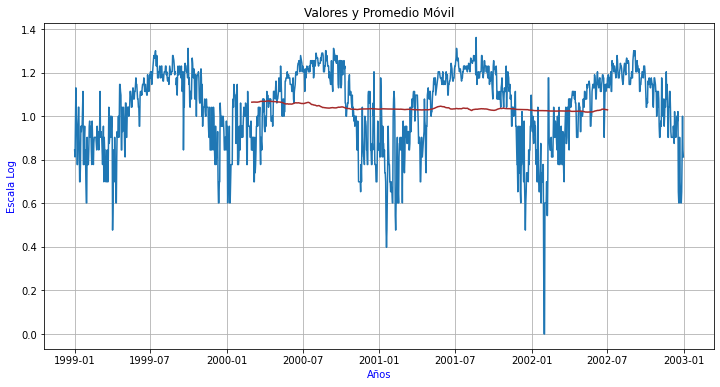

In [29]:
moving_avg = ts_test2_log.rolling(365, center=True).mean()
plt.plot(ts_test2_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [30]:
ts_test2_log_moving_ave_diff = ts_test2_log - moving_avg 
ts_test2_log_moving_ave_diff.head()

Fecha
1999-01-01   NaN
1999-01-02   NaN
1999-01-03   NaN
1999-01-04   NaN
1999-01-05   NaN
Name: Tmin, dtype: float64

In [31]:
ts_test2_log_moving_ave_diff.dropna(inplace=True)
ts_test2_log_moving_ave_diff.head()

Fecha
2000-03-01   -0.219388
2000-03-02   -0.161627
2000-03-03   -0.219768
2000-03-04   -0.161947
2000-03-05   -0.162240
Name: Tmin, dtype: float64

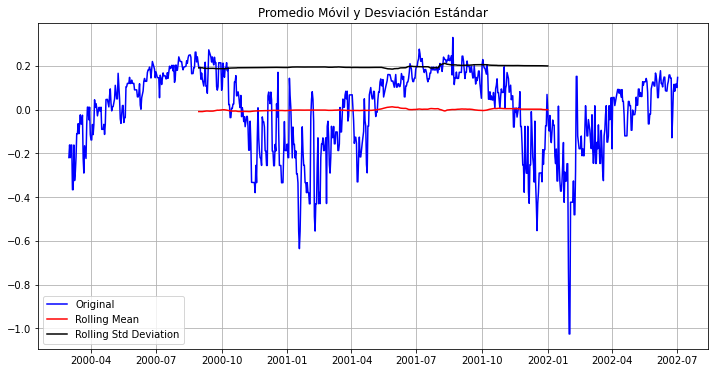

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -2.667362
p-value                          0.079858
#Lags Used                      11.000000
Number of Observations Used    842.000000
Critical Value (1%)             -3.438140
Critical Value (5%)             -2.864979
Critical Value (10%)            -2.568601
dtype: float64


In [32]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test2_log_moving_ave_diff)

$\text{Aún la serie de tiempo no es estacionaria. Cambiaremos el tipo de promedio móvil a Exponencial (Exponential Weighted Moving), función de pandas pd.ewm()}$

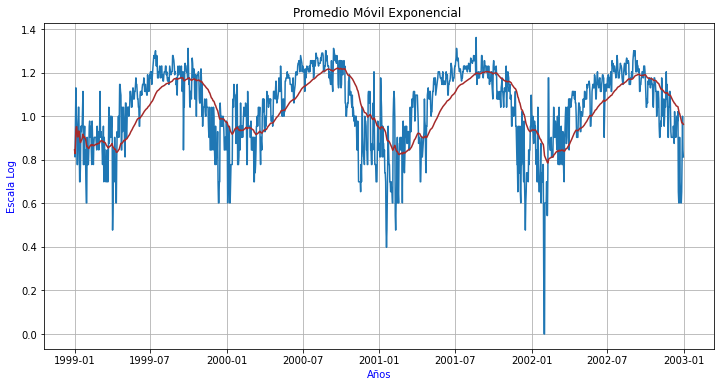

In [33]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_test2_log.ewm(halflife=30).mean()
plt.plot(ts_test2_log)
plt.plot(EWM_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [34]:
EWM_avg.head()

Fecha
1999-01-01    0.845098
1999-01-02    0.828820
1999-01-03    0.871597
1999-01-04    0.938540
1999-01-05    0.951406
Name: Tmin, dtype: float64

In [35]:
# Probamos la estacionarida de la diferencia 
ts_test2_log_EWM_avg_diff = ts_test2_log - EWM_avg

In [36]:
ts_test2_log_EWM_avg_diff.dropna(inplace=True)
ts_test2_log_EWM_avg_diff.head()

Fecha
1999-01-01    0.000000
1999-01-02   -0.015906
1999-01-03    0.082646
1999-01-04    0.191794
1999-01-05    0.048594
Name: Tmin, dtype: float64

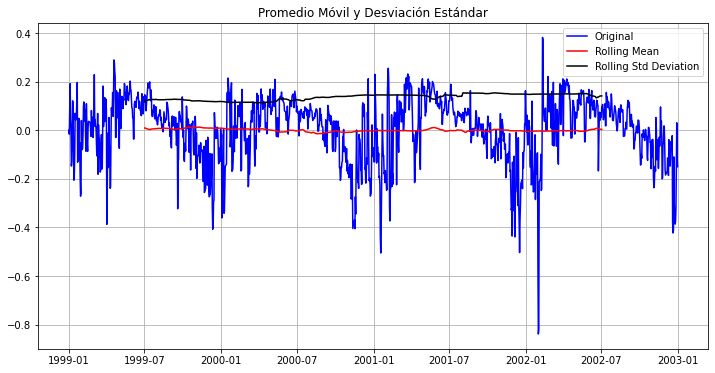

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.219581
p-value                           0.018879
#Lags Used                       24.000000
Number of Observations Used    1435.000000
Critical Value (1%)              -3.434915
Critical Value (5%)              -2.863556
Critical Value (10%)             -2.567843
dtype: float64


In [37]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test2_log_EWM_avg_diff)

$\text{Se puede observar que el valor p = 0.018879 < 0.05 por lo que podemos afirmar que la serie de tiempo es estacionaria con 99% de confianza.}$
$\text{Se puede decir que la serie es estacionaria, pues tanto el promedio móvil exponencial y la desviación estandar son constantes.}$


## $\text{Verificamos la Estacionalidad de Tmax}$

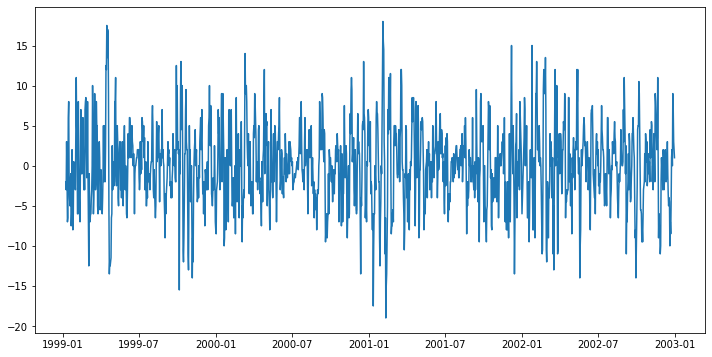

In [53]:
# Diferenciamos usando la función df.shift()
ts_test_diff = ts_test - ts_test.shift(periods=7)
plt.plot(ts_test_diff);

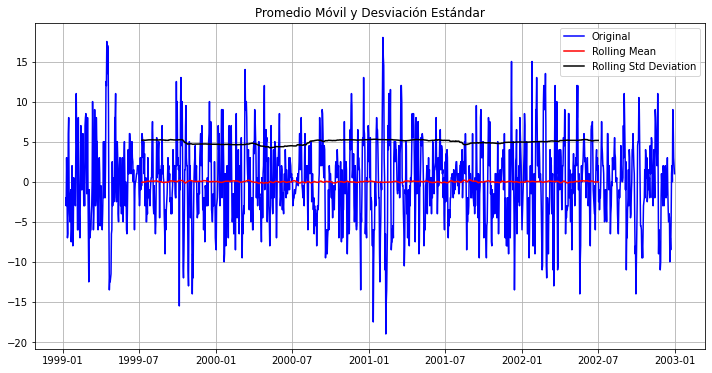

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.825361e+00
p-value                        5.205220e-17
#Lags Used                     2.200000e+01
Number of Observations Used    1.431000e+03
Critical Value (1%)           -3.434928e+00
Critical Value (5%)           -2.863562e+00
Critical Value (10%)          -2.567846e+00
dtype: float64


In [54]:
# Probamos la estacionaridad
ts_test_diff.dropna(inplace=True)
test_stationarity(ts_test_diff)

In [55]:
# Número de datos utilizados
len(ts_test_diff)

1454

$\text{Podemos decir que es estacionaria, el valor p < 0.05 y la desviación estándar no varía mucho.}$ 
$\text{Pero la estacionalidad domina, por lo que usaremos el siguiente método de descomposición.}$

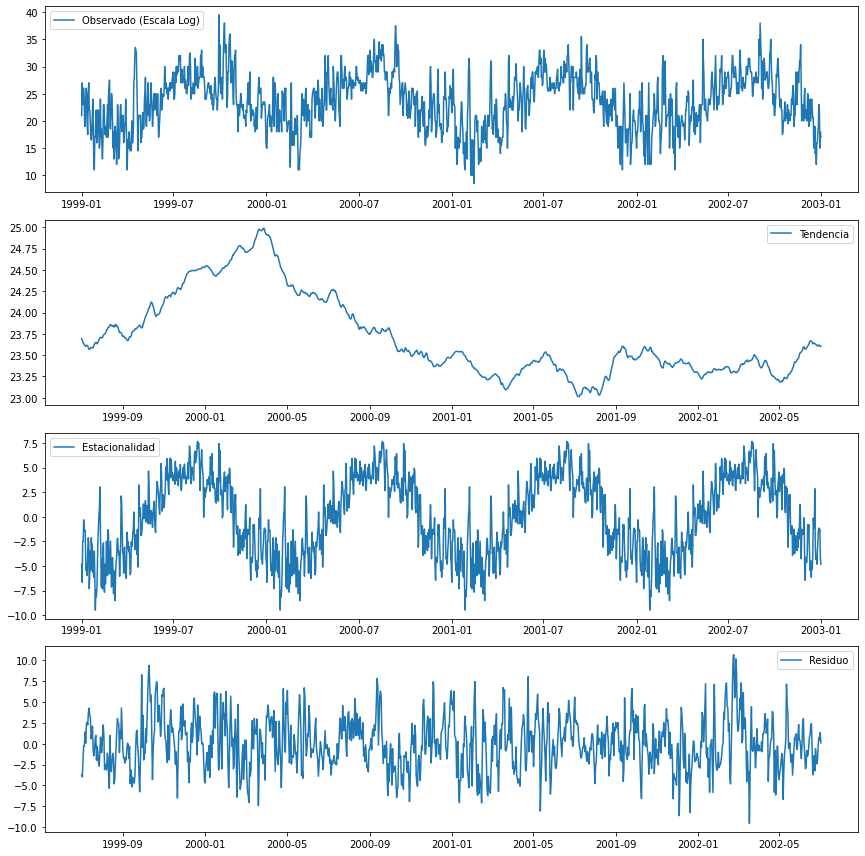

In [56]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

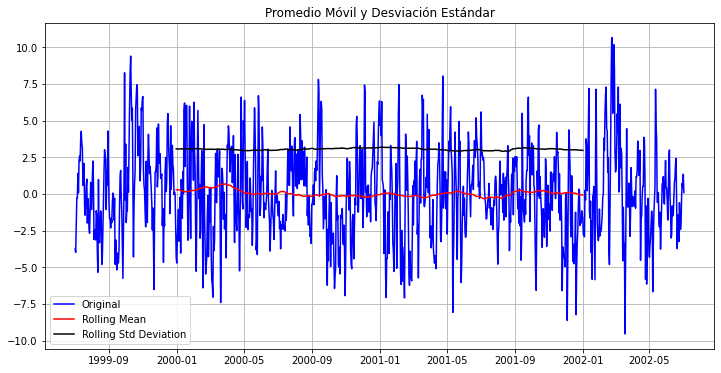

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -6.746437e+00
p-value                        3.026739e-09
#Lags Used                     2.200000e+01
Number of Observations Used    1.074000e+03
Critical Value (1%)           -3.436453e+00
Critical Value (5%)           -2.864235e+00
Critical Value (10%)          -2.568205e+00
dtype: float64


In [57]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_decompose = residue 
ts_test_decompose.dropna(inplace=True)
test_stationarity(ts_test_decompose)

$\text{Se puede observar que la serie es estacionaria porque la prueba da un valor de p = 3.026739 x 10^(-9) < 0.05. Podemos afirmar que es una serie de tiempo estacionaria con mas de un 99% de confianza.}$

## $\text{Verificamos la Estacionalidad de Tmin}$

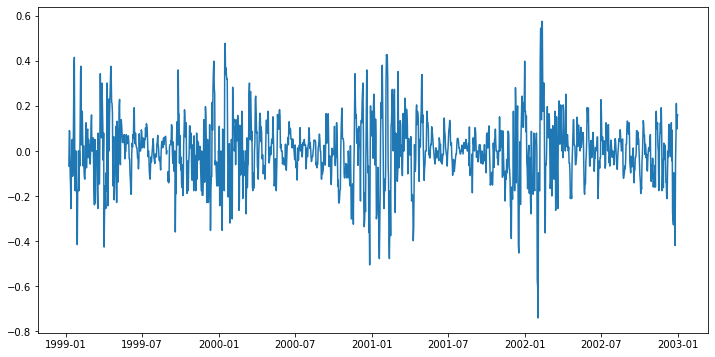

In [38]:
# Diferenciamos usando la función df.shift()
ts_test2_log_diff = ts_test2_log - ts_test2_log.shift(periods=7)
plt.plot(ts_test2_log_diff);

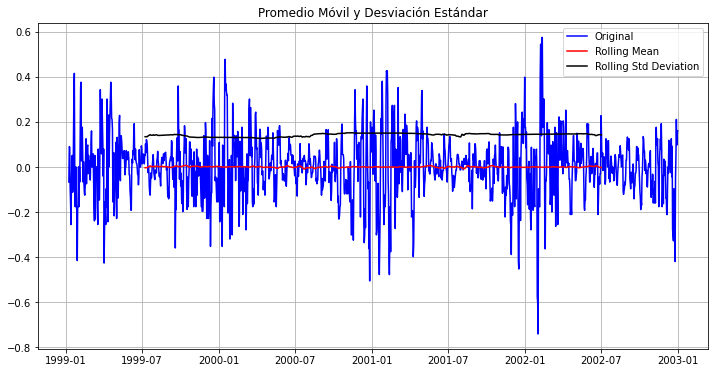

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.433175e+00
p-value                        5.124798e-16
#Lags Used                     2.100000e+01
Number of Observations Used    1.430000e+03
Critical Value (1%)           -3.434931e+00
Critical Value (5%)           -2.863563e+00
Critical Value (10%)          -2.567847e+00
dtype: float64


In [39]:
# Probamos la estacionaridad
ts_test2_log_diff.dropna(inplace=True)
test_stationarity(ts_test2_log_diff)

In [40]:
# Número de datos utilizados
len(ts_test2_log_diff)

1452

$\text{Podemos decir que es estacionaria, el valor p < 0.05 y la desviación estándar no varía mucho.}$ 
$\text{Pero la estacionalidad domina, por lo que usaremos el siguiente método de descomposición.}$

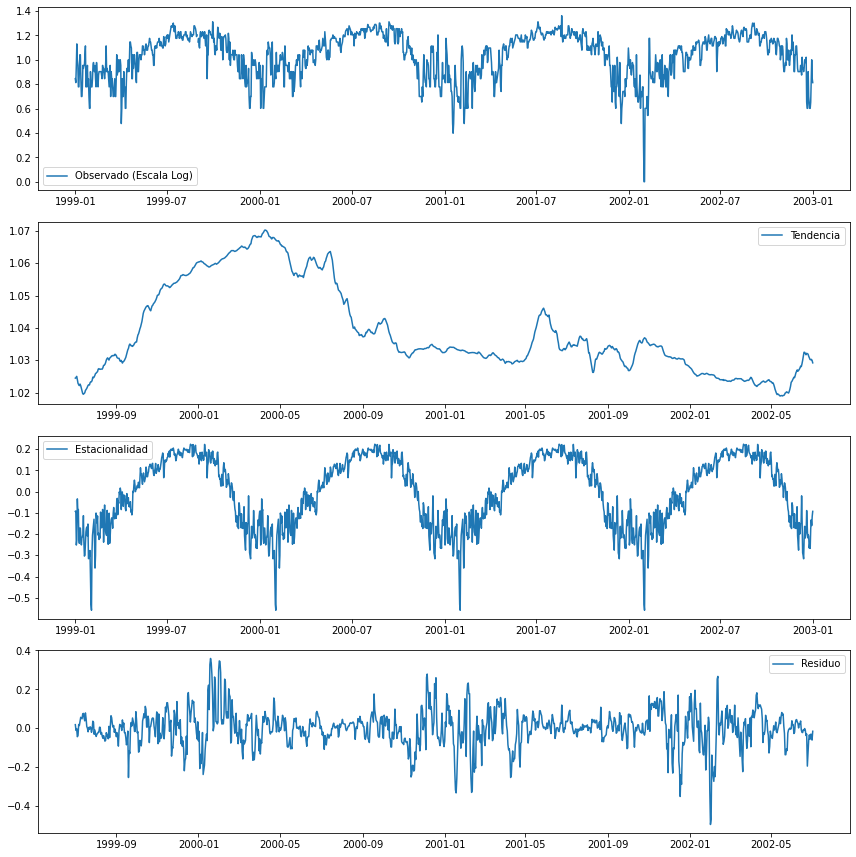

In [41]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test2_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test2_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

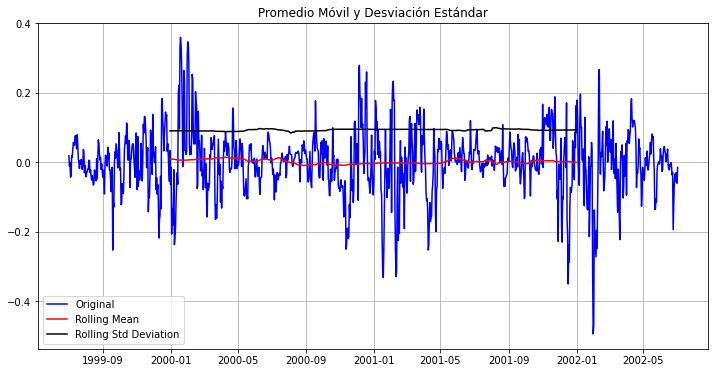

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.321397e+00
p-value                        9.870334e-16
#Lags Used                     7.000000e+00
Number of Observations Used    1.089000e+03
Critical Value (1%)           -3.436369e+00
Critical Value (5%)           -2.864198e+00
Critical Value (10%)          -2.568185e+00
dtype: float64


In [42]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)

$\text{Se puede observar que la serie es estacionaria porque la prueba da un valor de p = 9.870334 x 10^(-16) < 0.05. Podemos afirmar que es una serie de tiempo estacionaria con mas de un 99% de confianza.}$

## $\text{Pronóstico de Series de Tiempo}$

$\text{El objetivo es contruir un modelo utilizando diferenciación, y añadiremos el error, la tendencia y la estacionalidad a las predicciones.}$
$\text{Utilizaremos el método ARIMA.}$

### $\text{Método de ARIMA Tmax}$

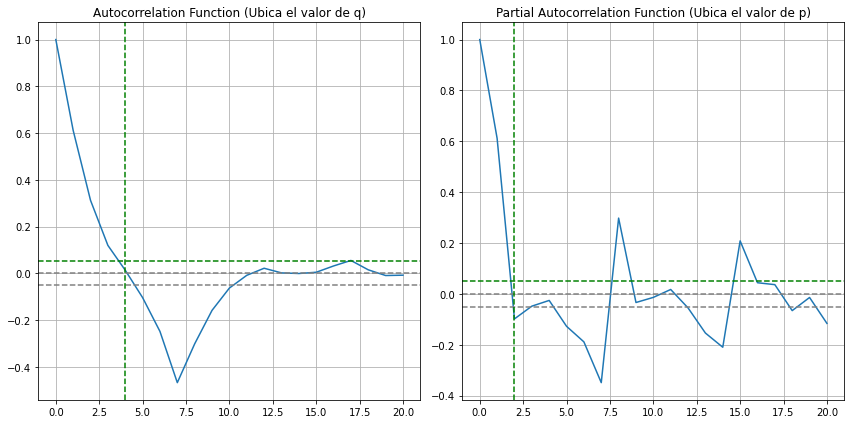

In [91]:
# Tmax
# Aplicamos ARIMA

lag_acf = acf(ts_test_diff, nlags=20)
lag_pacf = pacf(ts_test_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

$\text{Las líneas punteadas alrededor de cero representan los intervalos de confianza y nos serviran para determinar los valores p y q del modelo ARIMA.}$
$\text{p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.}$
$\text{q es donde cruza la ACF el primer nivel de confianza superior, cercano a 4, por lo que haremos q=4.}$
$\text{Con estos dos valores construiremos los modelos ARIMA correspondientes.}$

$\text{Modelo AR (Auto-Regresión) Tmax}$

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1460
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -3694.848
Method:                       css-mle   S.D. of innovations              3.040
Date:                Fri, 19 Feb 2021   AIC                           7397.696
Time:                        18:49:51   BIC                           7418.841
Sample:                    01-02-1999   HQIC                          7405.584
                         - 12-31-2002                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0035      0.060     -0.058      0.954      -0.121       0.114
ar.L1.D.Tmax    -0.1432      0.026     -5.563      0.000      -0.194      -0.093
ar.L2.D.Tmax    -0.1841      0.026     -7.14

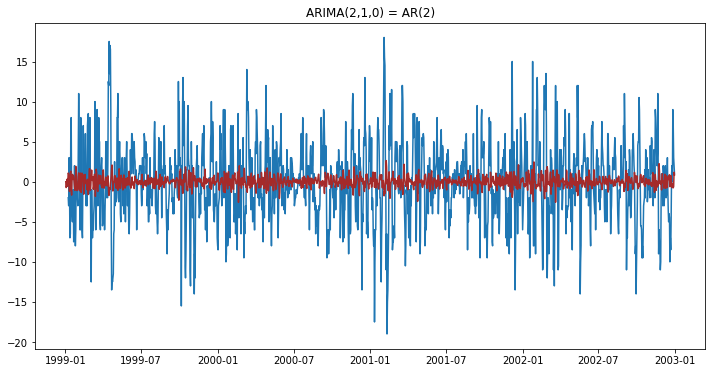

In [92]:
# Tmax
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

$\text{Modelo MA (Promedio Móvil) Tmax}$

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1460
Model:                 ARIMA(0, 1, 4)   Log Likelihood               -3611.142
Method:                       css-mle   S.D. of innovations              2.870
Date:                Fri, 19 Feb 2021   AIC                           7234.285
Time:                        18:49:55   BIC                           7266.002
Sample:                    01-02-1999   HQIC                          7246.117
                         - 12-31-2002                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0026      0.014     -0.179      0.858      -0.031       0.026
ma.L1.D.Tmax    -0.2779      0.026    -10.708      0.000      -0.329      -0.227
ma.L2.D.Tmax    -0.2731      0.027    -10.24

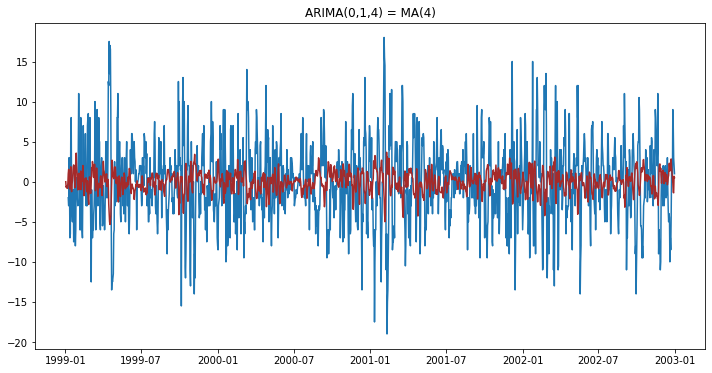

In [93]:
# Tmax
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

$\text{Modelo ARIMA (Auto-Regresión + Promedio Móvil) Tmax}$

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1460
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -3609.091
Method:                       css-mle   S.D. of innovations              2.865
Date:                Fri, 19 Feb 2021   AIC                           7234.181
Time:                        18:50:02   BIC                           7276.471
Sample:                    01-02-1999   HQIC                          7249.957
                         - 12-31-2002                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0023      0.014     -0.169      0.866      -0.029       0.024
ar.L1.D.Tmax    -0.5787      0.100     -5.801      0.000      -0.774      -0.383
ar.L2.D.Tmax     0.4054      0.097      4.18

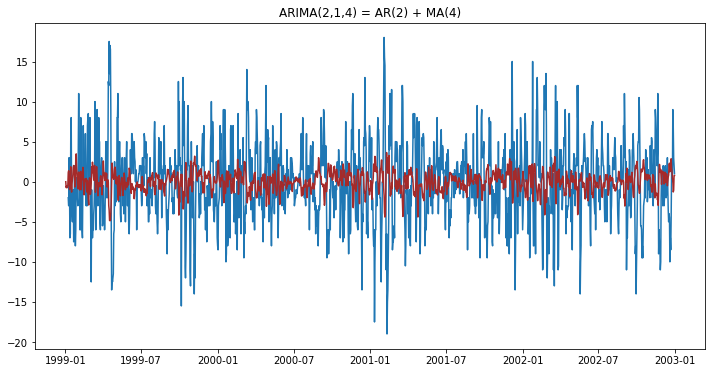

In [94]:
# Tmax
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

$\text{Verificamos el Criterio de Información de Akaike (AIC) para Tmax}$

*   $\text{ARIMA(2,1,0): AIC = 7397.696}$
*   $\text{ARIMA(0,1,4): AIC = 7234.285}$
*   $\text{ARIMA(2,1,4): AIC = 7234.181 <- Es el menor AIC}$

$\text{Al final, podemos ver que ARIMA(2,1,4) es el mejor modelo de los 3 explorados.}$

### $\text{Método de ARIMA Tmin}$

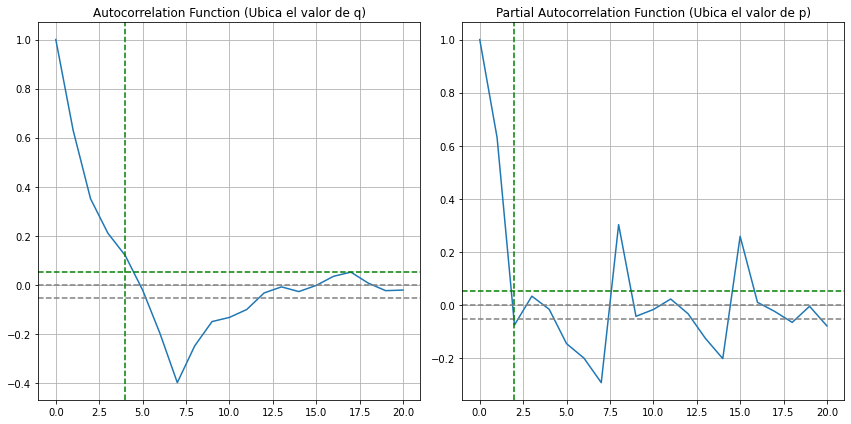

In [113]:
# Tmin
# Aplicamos ARIMA

lag_acf = acf(ts_test2_log_diff, nlags=20)
lag_pacf = pacf(ts_test2_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test2_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test2_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=5, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test2_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test2_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

$\text{Las líneas punteadas alrededor de cero representan los intervalos de confianza y nos serviran para determinar los valores p y q del modelo ARIMA.}$
$\text{p es donde cruza el PACF el primer nivel de confianza superior, que en la gráfica derecha es cercana a 2, por lo que p=2.}$
$\text{q es donde cruza la ACF el primer nivel de confianza superior, cercano a 4, por lo que haremos q=4.}$
$\text{Con estos dos valores construiremos los modelos ARIMA correspondientes.}$

$\text{Modelo AR (Auto-Regresión) Tmin}$

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1459
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1548.578
Method:                       css-mle   S.D. of innovations              0.084
Date:                Fri, 19 Feb 2021   AIC                          -3089.155
Time:                        18:51:17   BIC                          -3068.013
Sample:                             1   HQIC                         -3081.268
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -9.219e-06      0.002     -0.006      0.995      -0.003       0.003
ar.L1.D.Tmin    -0.1384      0.026     -5.406      0.000      -0.189      -0.088
ar.L2.D.Tmin    -0.2101      0.026     -8.19

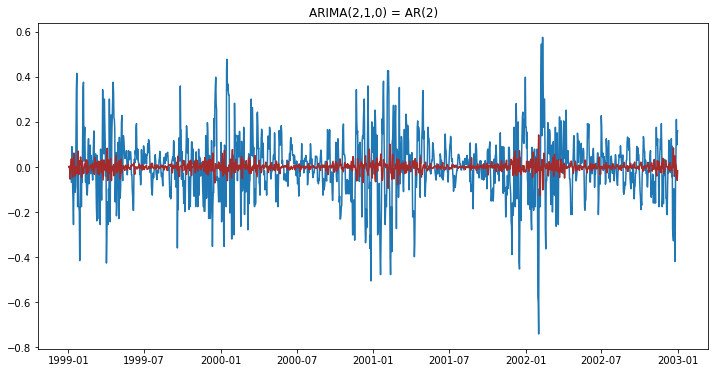

In [100]:
# Tmin
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test2_log, order=(2,1,0), missing='drop')
results2_AR = model.fit(displ=-1)
plt.plot(ts_test2_log_diff)
plt.plot(results2_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results2_AR.summary())

$\text{Modelo MA (Promedio Móvil) Tmin}$

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1459
Model:                 ARIMA(0, 1, 4)   Log Likelihood                1606.052
Method:                       css-mle   S.D. of innovations              0.080
Date:                Fri, 19 Feb 2021   AIC                          -3200.103
Time:                        18:51:20   BIC                          -3168.390
Sample:                             1   HQIC                         -3188.272
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.441e-05      0.001     -0.121      0.904      -0.001       0.001
ma.L1.D.Tmin    -0.2380      0.026     -9.123      0.000      -0.289      -0.187
ma.L2.D.Tmin    -0.2742      0.026    -10.39

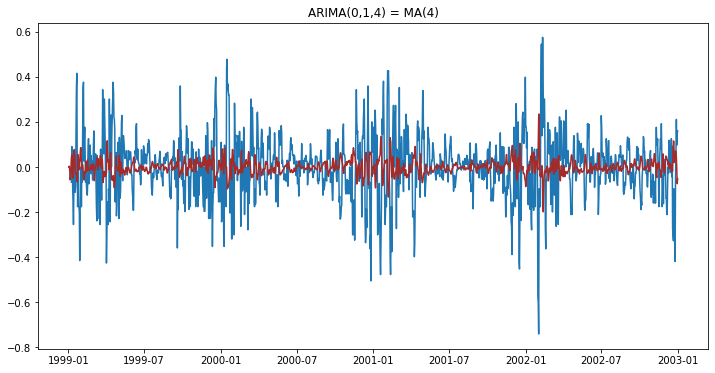

In [101]:
# Tmin
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test2_log, order=(0,1,4), missing='drop')
results2_MA = model.fit(displ=-1)
plt.plot(ts_test2_log_diff)
plt.plot(results2_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results2_MA.summary())

$\text{Modelo ARIMA (Auto-Regresión + Promedio Móvil) Tmin}$

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1459
Model:                 ARIMA(2, 1, 4)   Log Likelihood                1608.226
Method:                       css-mle   S.D. of innovations              0.080
Date:                Fri, 19 Feb 2021   AIC                          -3200.453
Time:                        18:51:25   BIC                          -3158.169
Sample:                             1   HQIC                         -3184.679
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.666e-05      0.001     -0.106      0.915      -0.001       0.001
ar.L1.D.Tmin     0.5969      0.560      1.067      0.286      -0.500       1.694
ar.L2.D.Tmin     0.0934      0.313      0.29

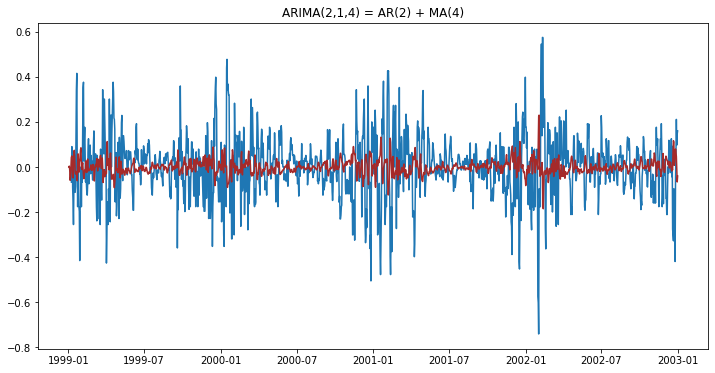

In [102]:
# Tmin
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test2_log, order=(2,1,4), missing='drop')
results2_ARIMA = model.fit(displ=-1)
plt.plot(ts_test2_log_diff)
plt.plot(results2_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results2_ARIMA.summary())

$\text{Verificamos el Criterio de Información de Akaike (AIC) para Tmin}$

*   $\text{ARIMA(2,1,0): AIC = -3089.155}$
*   $\text{ARIMA(0,1,4): AIC = -3200.103}$
*   $\text{ARIMA(2,1,4): AIC = -3200.453 <- Es el menor AIC}$

$\text{Al final, podemos ver que ARIMA(2,1,4) es el mejor modelo de los 3 explorados.}$

## $\text{Recolectando todo y regresando a la escala original}$

$\text{Pasos a seguir:}$

*   $\text{Obtener los valores de la predicción y convertirlos en serie. Observaremos que falta un valor en el inicio (usamos shift=1).}$
*   $\text{Para la serie de Tmin, convertir la diferenciación a escala logarítmica.}$



In [95]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions2_ARIMA_diff = pd.Series(results2_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)
print(predictions2_ARIMA_diff)

Fecha
1999-01-02   -0.002298
1999-01-03   -0.732583
1999-01-04   -0.536228
1999-01-05   -0.752061
1999-01-06   -0.686977
                ...   
2002-12-27    0.137638
2002-12-28   -1.277310
2002-12-29   -1.086956
2002-12-30    0.753765
2002-12-31    0.775272
Length: 1460, dtype: float64
Fecha
1999-01-02   -0.000057
1999-01-03    0.003631
1999-01-04   -0.012901
1999-01-05   -0.059006
1999-01-06   -0.044670
                ...   
2002-12-27    0.062726
2002-12-28    0.046827
2002-12-29   -0.004824
2002-12-30   -0.066456
2002-12-31   -0.039985
Length: 1459, dtype: float64


In [96]:
# Tmax
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test)
predictions_ARIMA = pd.Series(ts_test, index = ts_test.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff)
print(predictions_ARIMA.head())
print(predictions_ARIMA.tail())

# Tmin
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test2_log)
predictions2_ARIMA_log = pd.Series(ts_test2_log, index = ts_test2_log.index)
predictions2_ARIMA_log = predictions2_ARIMA_log.add(predictions2_ARIMA_diff)
print(predictions2_ARIMA_log.head())
print(predictions2_ARIMA_log.tail())

Fecha
1999-01-01          NaN
1999-01-02    26.997702
1999-01-03    22.267417
1999-01-04    25.463772
1999-01-05    25.247939
dtype: float64
Fecha
2002-12-27    23.137638
2002-12-28    20.722690
2002-12-29    13.913044
2002-12-30    18.753765
2002-12-31    17.775272
dtype: float64
Fecha
1999-01-01         NaN
1999-01-02    0.812857
1999-01-03    0.957873
1999-01-04    1.117433
1999-01-05    0.940994
dtype: float64
Fecha
2002-12-27    0.715938
2002-12-28    0.859740
2002-12-29    0.995176
2002-12-30    0.778642
2002-12-31    0.772929
dtype: float64


## $\text{Sobreponiendo gráficamente ambas series, la observada y la construida con el método ARIMA.}$

### $\text{Gráficas de Tmax}$

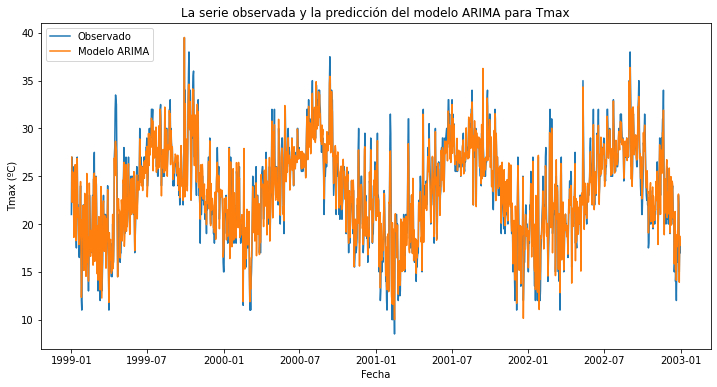

In [116]:
# Para Tmax, graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráficas
plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');

# Ejes
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')

# Título y leyenda
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

$\text{Para una mejor visualización, graficamos los últimos datos.}$

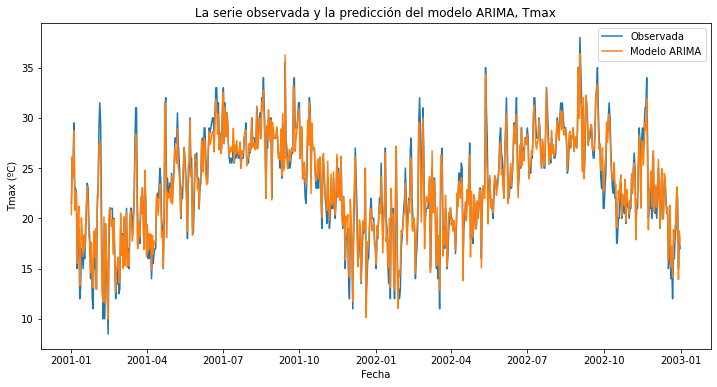

In [117]:
# Graficamos sólo los útimos datos de la serie Tmax
ts_test_last = ts_test.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)

plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');

plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA, Tmax')
plt.legend(loc='best');

### $\text{Gráficas de Tmin}$

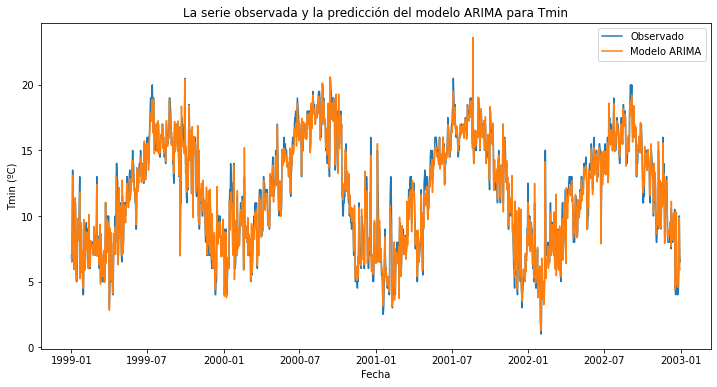

In [118]:
# Tmin
# Regresamos a la escala de Temperatura original 
predictions2_ARIMA = 10**(predictions2_ARIMA_log)

# Para Tmin, graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráficas
plt.plot(ts_test2, label='Observado');
plt.plot(predictions2_ARIMA, label='Modelo ARIMA');

# Ejes
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')

# Título y leyenda
plt.title('La serie observada y la predicción del modelo ARIMA para Tmin')
plt.legend(loc='best');

$\text{Para una mejor visualización, graficamos los últimos datos.}$

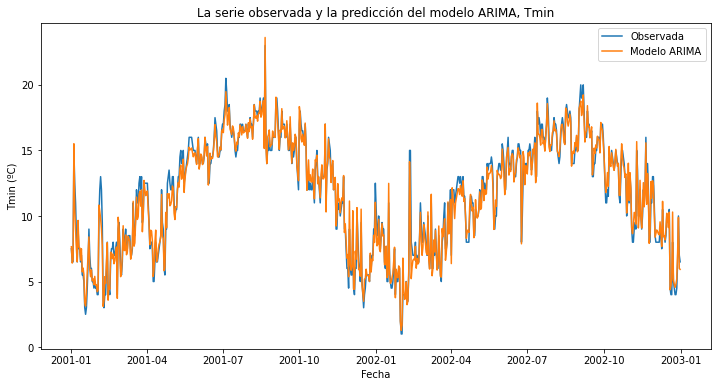

In [119]:
# Graficamos sólo los útimos datos de la serie Tmin
ts_test2_last = ts_test2.tail(730)
predictions2_ARIMA_last = predictions2_ARIMA.tail(730)

plt.plot(ts_test2_last, label='Observada');
plt.plot(predictions2_ARIMA_last, label='Modelo ARIMA');

plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA, Tmin')
plt.legend(loc='best');

## $\text{Error de la raíz cuadrada promedio RMSE}$

$\text{Error de la raíz cuadrada promedio RMSE para Tmax}$

In [106]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 1.218790082464162


$\text{Error de la raíz cuadrada promedio RMSE para Tmin}$

In [107]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE2 = np.sqrt(np.mean((predictions2_ARIMA - ts_test2)**2))
print('RMSE:', RMSE2)

RMSE: 0.6648548710865327
